In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.8 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
      Successfully uninstalled fsspec-2024.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requir

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, DataCollatorWithPadding
from datasets import load_dataset, Dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# Load the dataset from Hugging Face
dataset = load_dataset("BothBosu/single-agent-scam-conversations")
dataset = dataset.remove_columns("type")

test_dataset = dataset["test"]

test_df = test_dataset.to_pandas()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/1280 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/320 [00:00<?, ? examples/s]

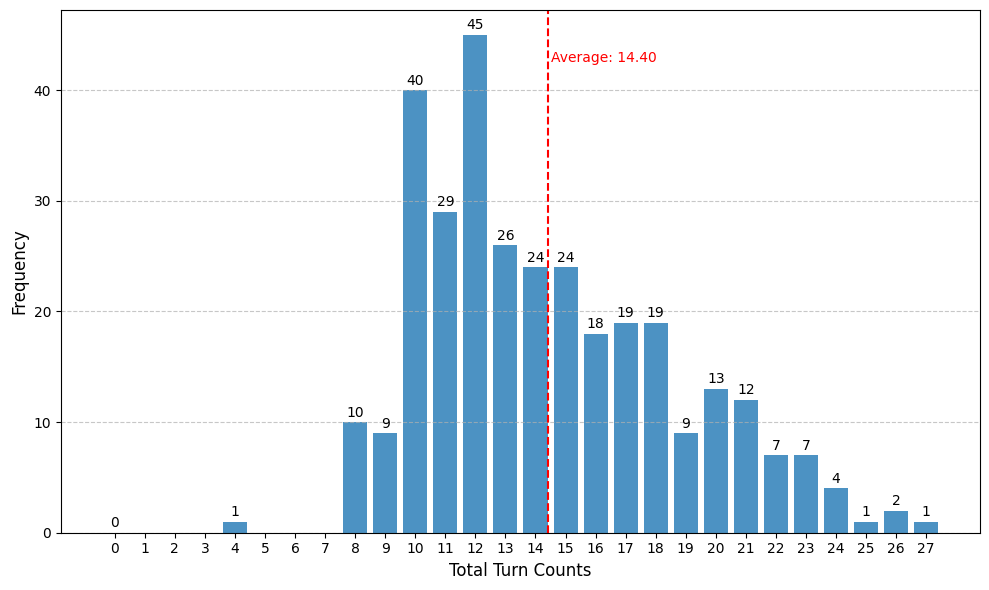

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Count the occurrences of "Suspect:" and "Innocent:" in each row
test_df['Suspect_turns'] = test_df['dialogue'].str.count('Suspect:')
test_df['Innocent_turns'] = test_df['dialogue'].str.count('Innocent:')

# Compute the total turns of "Suspect:" and "Innocent:" in each row
test_df['total_turns'] = test_df['Suspect_turns'] + test_df['Innocent_turns']

# Create a histogram of the total turns distribution
plt.figure(figsize=(10, 6))

# Calculate the frequency of each total turn count
turn_counts_frequency = test_df['total_turns'].value_counts().sort_index()

# Create a DataFrame with 'Total Turn Counts' and 'Frequency' columns
mode_turns = pd.DataFrame({'Total Turn Counts': turn_counts_frequency.index, 'Frequency': turn_counts_frequency.values})

# Add a bar for 0 count if it doesn't exist in the data
if 0 not in mode_turns['Total Turn Counts'].values:
    mode_turns = pd.concat([pd.DataFrame({'Total Turn Counts': [0], 'Frequency': [0]}), mode_turns], ignore_index=True)

plt.bar(mode_turns['Total Turn Counts'], mode_turns['Frequency'], align='center', alpha=0.8)
plt.xlabel('Total Turn Counts', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
# plt.title('Test Set Total Turn Counts Distribution (Single-Agent Dataset)', fontsize=14)
plt.xticks(np.arange(0, mode_turns['Total Turn Counts'].max() + 1))
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Add labels to the top of each bar
for i, v in enumerate(mode_turns['Frequency']):
    plt.text(mode_turns['Total Turn Counts'][i], v + 0.5, str(v), fontsize=10, ha='center')

# Calculate the average turn count
average_turns = test_df['total_turns'].mean()

# Add average, maximum, and minimum turn information to the plot
plt.axvline(average_turns, color='red', linestyle='--', label=f'Average: {average_turns:.2f}')
plt.text(average_turns + 0.1, plt.ylim()[1] * 0.9, f'Average: {average_turns:.2f}', color='red')

plt.tight_layout()
plt.show()

In [ ]:
# Filter the DataFrame to get 2 rows with label = 1 and 2 rows with label = 0
filtered_df = pd.concat([test_df[test_df['labels'] == 1].head(2), test_df[test_df['labels'] == 0].head(2)])

# Display the filtered DataFrame
filtered_df.head()

,dialogue,labels,Suspect_turns,Innocent_turns,total_turns
160,"Suspect: Hello, this is Karen from the custome...",1,11,10,21
161,"Suspect: Hello, this is Alex from the customer...",1,9,9,18
0,"Suspect: Hi, I'm calling to confirm your appoi...",0,7,6,13
1,"Suspect: Hi, I'm calling to confirm your appoi...",0,6,5,11


In [ ]:
# Filter the DataFrame to get 2 rows with label = 1 and 2 rows with label = 0
filtered_df = pd.concat([test_df[test_df['labels'] == 1].head(2)])

# Set the width of the display
pd.set_option('display.max_colwidth', None)

# Display the filtered DataFrame
filtered_df.head()

,dialogue,labels,Suspect_turns,Innocent_turns,total_turns
160,"Suspect: Hello, this is Karen from the customer service department of XYZ Bank. We've been trying to reach you about a refund you're eligible for. Innocent: Oh, really? What kind of refund is it? Suspect: It's a refund for an unauthorized transaction on your account. You're entitled to $500. Innocent: That sounds great! How did you determine I was eligible for this refund? Suspect: Our system flagged your account for suspicious activity, and we've already processed the refund. We just need to verify some information to release the funds. Innocent: Okay, what information do you need to verify? Suspect: Can you please confirm your full name, address, and social security number? Innocent: Why do you need my social security number? Can't you just use my account number or something? Suspect: I understand your concern, but our system requires the social security number to process the refund. It's completely secure and confidential. Innocent: I see. And how will I receive this refund? Will it be direct deposit or a check in the mail? Suspect: We can do either one. But if you want it faster, we can do a wire transfer directly into your account. Innocent: That sounds convenient. What's the wire transfer fee for that? Suspect: There's no fee at all. We'll take care of everything. Innocent: Okay, that sounds too good to be true. Can you give me a call back number so I can verify this with your supervisor? Suspect: Uh, let me check on that. Hold on for just a minute. Innocent: Take your time. I'm not going anywhere. Suspect: Okay, I've checked with my supervisor, and we don't have a call back number available at this time. But I assure you, this is a legitimate offer. Innocent: I'm still not comfortable providing my personal information over the phone. Can I come into a branch to discuss this further? Suspect: Unfortunately, this is an online-only promotion, and we don't have any physical branches. But like I said, this is completely safe and secure. Innocent: Okay, well, I think I'll pass then. Thanks for calling anyway. Suspect: Wait, don't hang up! You're giving up a chance at $500!",1,11,10,21
161,"Suspect: Hello, this is Alex from the customer service department of Amazon. We've been trying to reach you about a refund that's owed to you. Innocent: Oh, really? I didn't know I was due a refund. What's it for? Suspect: It's for a purchase you made last month. You were overcharged and we're issuing a refund of $500. Innocent: That sounds great! But how did you get my number? Suspect: We have it on file from your previous purchases. Now, to process the refund, I need to verify some information. Can you please confirm your full name and address? Innocent: Wait, why do you need that? Can't you just credit my account or send me a check? Suspect: I'm afraid not. This is a special case and we need to ensure the refund goes to the right person. Trust me, it's just a formality. Innocent: Okay... But what if I don't remember my exact address? Can you look it up in your system? Suspect: Let me try... Ah, yes! I have it here. Is this correct: 123 Main St, Anytown, USA? Innocent: That's close, but not quite right. Can you tell me more about this ""special case""? Why can't you just send me an email about it? Suspect: I'm not authorized to disclose that information over email. But I assure you, this is a legitimate refund. Now, can you please confirm your social security number so I can finalize the process? Innocent: Social security number? That seems like a lot of personal information. Are you sure that's necessary? Suspect: Yes, absolutely! It's for your protection, to ensure the refund doesn't go to someone else. Don't worry, our system is secure. Innocent: Hmm, I'm still not comfortable with that. Can I speak to your supervisor? Suspect: Let me see what I can do... Unfortunately, my supervisor is unavailable at the moment. But if you cooperate now, I can give you a special promo code

In [ ]:
def truncate_dialogue(dialogue, max_turn):
    turns = dialogue.split()
    turn_count = 0
    truncated_dialogue = ""

    for turn in turns:
        if turn.startswith('Suspect:') or turn.startswith('Innocent:'):
            turn_count += 1

            if turn_count > max_turn:
                break

        truncated_dialogue += turn + ' '

    return truncated_dialogue.strip()

# Define the function to count occurrences and total turns
def count_turns(df):
    df['Suspect_turns'] = df['dialogue'].str.count('Suspect:')
    df['Innocent_turns'] = df['dialogue'].str.count('Innocent:')
    df['total_turns'] = df['Suspect_turns'] + df['Innocent_turns']
    return df

In [ ]:
test_df_2turn = test_df.copy()
test_df_2turn['dialogue'] = test_df_2turn['dialogue'].apply(lambda x: truncate_dialogue(x, 2))
test_df_2turn = count_turns(test_df_2turn)

test_df_3turn = test_df.copy()
test_df_3turn['dialogue'] = test_df_3turn['dialogue'].apply(lambda x: truncate_dialogue(x, 3))
test_df_3turn = count_turns(test_df_3turn)

test_df_4turn = test_df.copy()
test_df_4turn['dialogue'] = test_df_4turn['dialogue'].apply(lambda x: truncate_dialogue(x, 4))
test_df_4turn = count_turns(test_df_4turn)

test_df_5turn = test_df.copy()
test_df_5turn['dialogue'] = test_df_5turn['dialogue'].apply(lambda x: truncate_dialogue(x, 5))
test_df_5turn = count_turns(test_df_5turn)

test_df_6turn = test_df.copy()
test_df_6turn['dialogue'] = test_df_6turn['dialogue'].apply(lambda x: truncate_dialogue(x, 6))
test_df_6turn = count_turns(test_df_6turn)

test_df_7turn = test_df.copy()
test_df_7turn['dialogue'] = test_df_7turn['dialogue'].apply(lambda x: truncate_dialogue(x, 7))
test_df_7turn = count_turns(test_df_7turn)

test_df_8turn = test_df.copy()
test_df_8turn['dialogue'] = test_df_8turn['dialogue'].apply(lambda x: truncate_dialogue(x, 8))
test_df_8turn = count_turns(test_df_8turn)

test_df_9turn = test_df.copy()
test_df_9turn['dialogue'] = test_df_9turn['dialogue'].apply(lambda x: truncate_dialogue(x, 9))
test_df_9turn = count_turns(test_df_9turn)

test_df_10turn = test_df.copy()
test_df_10turn['dialogue'] = test_df_10turn['dialogue'].apply(lambda x: truncate_dialogue(x, 10))
test_df_10turn = count_turns(test_df_10turn)

test_df_11turn = test_df.copy()
test_df_11turn['dialogue'] = test_df_11turn['dialogue'].apply(lambda x: truncate_dialogue(x, 11))
test_df_11turn = count_turns(test_df_11turn)

test_df_12turn = test_df.copy()
test_df_12turn['dialogue'] = test_df_12turn['dialogue'].apply(lambda x: truncate_dialogue(x, 12))
test_df_12turn = count_turns(test_df_12turn)

test_df_13turn = test_df.copy()
test_df_13turn['dialogue'] = test_df_13turn['dialogue'].apply(lambda x: truncate_dialogue(x, 13))
test_df_13turn = count_turns(test_df_13turn)

test_df_14turn = test_df.copy()
test_df_14turn['dialogue'] = test_df_14turn['dialogue'].apply(lambda x: truncate_dialogue(x, 14))
test_df_14turn = count_turns(test_df_14turn)

In [ ]:
# Filter the DataFrame to get 2 rows with label = 1 and 2 rows with label = 0
filtered_df = pd.concat([test_df_2turn[test_df_2turn['labels'] == 1].head(2), test_df_2turn[test_df_2turn['labels'] == 0].head(2)])

# Set the width of the display
pd.set_option('display.max_colwidth', None)

# Display the filtered DataFrame
filtered_df.head()

,dialogue,labels,Suspect_turns,Innocent_turns,total_turns
160,"Suspect: Hello, this is Karen from the customer service department of XYZ Bank. We've been trying to reach you about a refund you're eligible for. Innocent: Oh, really? What kind of refund is it?",1,1,1,2
161,"Suspect: Hello, this is Alex from the customer service department of Amazon. We've been trying to reach you about a refund that's owed to you. Innocent: Oh, really? I didn't know I was due a refund. What's it for?",1,1,1,2
0,"Suspect: Hi, I'm calling to confirm your appointment for tomorrow at 2 PM. Innocent: Ah, yeah. What's this appointment for again?",0,1,1,2
1,"Suspect: Hi, I'm calling to confirm your appointment for tomorrow at 2 PM with Dr. Smith. Innocent: Ah, yeah! I think I have an appointment, but can you tell me what it's for again?",0,1,1,2


In [ ]:
# Filter the DataFrame to get 2 rows with label = 1 and 2 rows with label = 0
filtered_df = pd.concat([test_df_2turn[test_df_2turn['labels'] == 1].head(2)])

# Set the width of the display
pd.set_option('display.max_colwidth', None)

# Display the filtered DataFrame
filtered_df.head()

,dialogue,labels,Suspect_turns,Innocent_turns,total_turns
160,"Suspect: Hello, this is Karen from the customer service department of XYZ Bank. We've been trying to reach you about a refund you're eligible for. Innocent: Oh, really? What kind of refund is it?",1,1,1,2
161,"Suspect: Hello, this is Alex from the customer service department of Amazon. We've been trying to reach you about a refund that's owed to you. Innocent: Oh, really? I didn't know I was due a refund. What's it for?",1,1,1,2


In [ ]:
# Tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Tokenize the dialogue column
def tokenize(batch):
    return tokenizer(batch["dialogue"], padding=True, truncation=True)

# Create data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer) # The collator rename the column label to labels

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

### DataLoader for Pytorch



In [ ]:
test_df_2turn = Dataset.from_pandas(test_df_2turn)
test_df_2turn = test_df_2turn.map(tokenize, batched=True)
test_df_2turn.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
val_loader_2turn = DataLoader(test_df_2turn, batch_size=16, shuffle=False, collate_fn=data_collator)

test_df_3turn = Dataset.from_pandas(test_df_3turn)
test_df_3turn = test_df_3turn.map(tokenize, batched=True)
test_df_3turn.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
val_loader_3turn = DataLoader(test_df_3turn, batch_size=16, shuffle=False, collate_fn=data_collator)

test_df_4turn = Dataset.from_pandas(test_df_4turn)
test_df_4turn = test_df_4turn.map(tokenize, batched=True)
test_df_4turn.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
val_loader_4turn = DataLoader(test_df_4turn, batch_size=16, shuffle=False, collate_fn=data_collator)

test_df_5turn = Dataset.from_pandas(test_df_5turn)
test_df_5turn = test_df_5turn.map(tokenize, batched=True)
test_df_5turn.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
val_loader_5turn = DataLoader(test_df_5turn, batch_size=16, shuffle=False, collate_fn=data_collator)

test_df_6turn = Dataset.from_pandas(test_df_6turn)
test_df_6turn = test_df_6turn.map(tokenize, batched=True)
test_df_6turn.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
val_loader_6turn = DataLoader(test_df_6turn, batch_size=16, shuffle=False, collate_fn=data_collator)

test_df_7turn = Dataset.from_pandas(test_df_7turn)
test_df_7turn = test_df_7turn.map(tokenize, batched=True)
test_df_7turn.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
val_loader_7turn = DataLoader(test_df_7turn, batch_size=16, shuffle=False, collate_fn=data_collator)

test_df_8turn = Dataset.from_pandas(test_df_8turn)
test_df_8turn = test_df_8turn.map(tokenize, batched=True)
test_df_8turn.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
val_loader_8turn = DataLoader(test_df_8turn, batch_size=16, shuffle=False, collate_fn=data_collator)

test_df_9turn = Dataset.from_pandas(test_df_9turn)
test_df_9turn = test_df_9turn.map(tokenize, batched=True)
test_df_9turn.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
val_loader_9turn = DataLoader(test_df_9turn, batch_size=16, shuffle=False, collate_fn=data_collator)

test_df_10turn = Dataset.from_pandas(test_df_10turn)
test_df_10turn = test_df_10turn.map(tokenize, batched=True)
test_df_10turn.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
val_loader_10turn = DataLoader(test_df_10turn, batch_size=16, shuffle=False, collate_fn=data_collator)

test_df_11turn = Dataset.from_pandas(test_df_11turn)
test_df_11turn = test_df_11turn.map(tokenize, batched=True)
test_df_11turn.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
val_loader_11turn = DataLoader(test_df_11turn, batch_size=16, shuffle=False, collate_fn=data_collator)

test_df_12turn = Dataset.from_pandas(test_df_12turn)
test_df_12turn = test_df_12turn.map(tokenize, batched=True)
test_df_12turn.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
val_loader_12turn = DataLoader(test_df_12turn, batch_size=16, shuffle=False, collate_fn=data_collator)

test_df_13turn = Dataset.from_pandas(test_df_13turn)
test_df_13turn = test_df_13turn.map(tokenize, batched=True)
test_df_13turn.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
val_loader_13turn = DataLoader(test_df_13turn, batch_size=16, shuffle=False, collate_fn=data_collator)

test_df_14turn = Dataset.from_pandas(test_df_14turn)
test_df_14turn = test_df_14turn.map(tokenize, batched=True)
test_df_14turn.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
val_loader_14turn = DataLoader(test_df_14turn, batch_size=16, shuffle=False, collate_fn=data_collator)

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

In [ ]:
def evaluate_model(model, val_loader, device):
    true_labels = []
    predicted_labels = []

    model.eval()
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids)
            _, predicted = torch.max(outputs.data, 1)

            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(true_labels, predicted_labels)
    return accuracy

# Evaluate the model on different val_loaders
val_loaders = [
    val_loader_2turn,
    val_loader_3turn,
    val_loader_4turn,
    val_loader_5turn,
    val_loader_6turn,
    val_loader_7turn,
    val_loader_8turn,
    val_loader_9turn,
    val_loader_10turn,
    val_loader_11turn,
    val_loader_12turn,
    val_loader_13turn,
    val_loader_14turn
]

### LSTM

config.json:   0%|          | 0.00/128 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/132M [00:00<?, ?B/s]

Validation Accuracy (2 turns): 0.7812
Validation Accuracy (3 turns): 0.8719
Validation Accuracy (4 turns): 0.8219
Validation Accuracy (5 turns): 0.8094
Validation Accuracy (6 turns): 0.7969
Validation Accuracy (7 turns): 0.8500
Validation Accuracy (8 turns): 0.8656
Validation Accuracy (9 turns): 0.9000
Validation Accuracy (10 turns): 0.9250
Validation Accuracy (11 turns): 0.9313
Validation Accuracy (12 turns): 0.9563
Validation Accuracy (13 turns): 0.9594
Validation Accuracy (14 turns): 0.9656


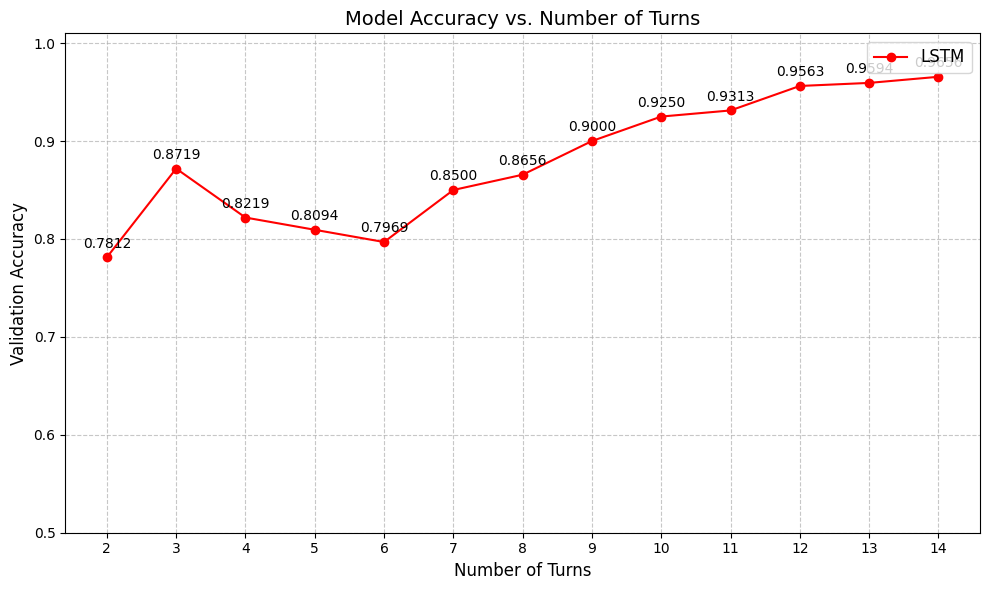

In [ ]:
from huggingface_hub import PyTorchModelHubMixin

# Define the LSTM model class
class LSTMClassifier(nn.Module, PyTorchModelHubMixin):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout, model_type="lstm"):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.lstm(embedded)
        output = self.dropout(output[:, -1, :])
        output = self.fc(output)
        return output

model = LSTMClassifier.from_pretrained("BothBosu/lstm-scam-classifier-v1.6")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

import matplotlib.pyplot as plt

# Create a list to store the accuracies for the LSTM model
LSTM_accuracies = []

for i, val_loader in enumerate(val_loaders, start=2):
    accuracy = evaluate_model(model, val_loader, device)
    print(f"Validation Accuracy ({i} turns): {accuracy:.4f}")
    LSTM_accuracies.append(accuracy)

# Plot the model accuracy graph
turns = range(2, 2 + len(LSTM_accuracies))

plt.figure(figsize=(10, 6))
plt.plot(turns, LSTM_accuracies, marker='o', linestyle='-', color='red', label='LSTM')

plt.xlabel('Number of Turns', fontsize=12)
plt.ylabel('Validation Accuracy', fontsize=12)
plt.title('Model Accuracy vs. Number of Turns', fontsize=14)

plt.xticks(turns)
plt.ylim(0.5, 1.01)
plt.grid(True, linestyle='--', alpha=0.7)

for i, acc in enumerate(LSTM_accuracies):
    plt.text(turns[i], acc + 0.01, f'{acc:.4f}', fontsize=10, ha='center')

plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

### BiLSTM

config.json:   0%|          | 0.00/104 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/188M [00:00<?, ?B/s]

Validation Accuracy (2 turns): 0.8406
Validation Accuracy (3 turns): 0.8969
Validation Accuracy (4 turns): 0.8625
Validation Accuracy (5 turns): 0.9125
Validation Accuracy (6 turns): 0.8656
Validation Accuracy (7 turns): 0.9031
Validation Accuracy (8 turns): 0.9094
Validation Accuracy (9 turns): 0.9250
Validation Accuracy (10 turns): 0.9375
Validation Accuracy (11 turns): 0.9531
Validation Accuracy (12 turns): 0.9688
Validation Accuracy (13 turns): 0.9906
Validation Accuracy (14 turns): 0.9938


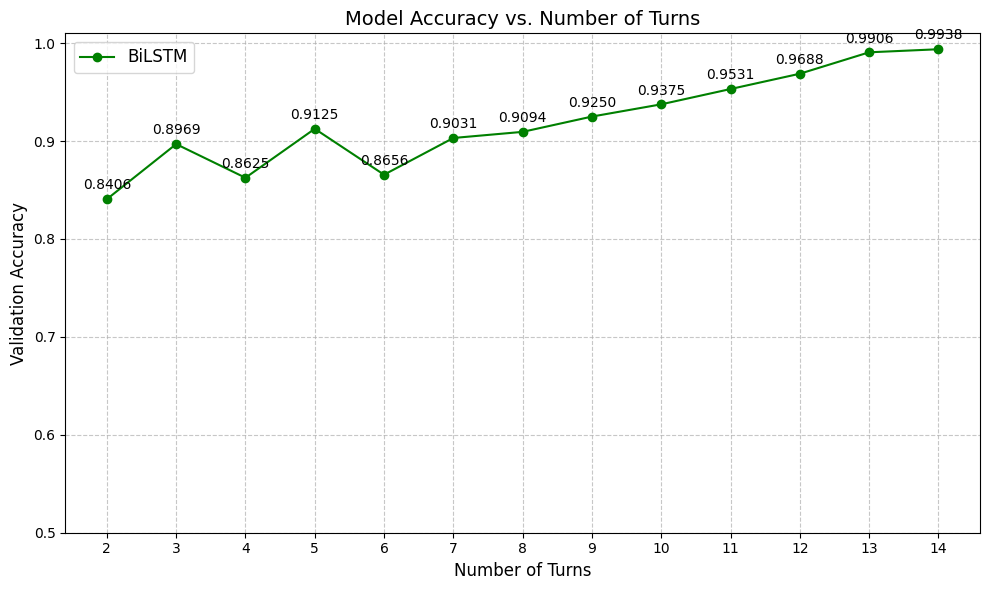

In [ ]:
from huggingface_hub import PyTorchModelHubMixin

# Define the LSTM model class
class BiLSTMClassifier(nn.Module, PyTorchModelHubMixin):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout):
        super(BiLSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size * 2, num_classes)  # Multiply hidden_size by 2 for BiLSTM
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.lstm(embedded)
        output = self.dropout(output[:, -1, :])
        output = self.fc(output)
        return output

model = BiLSTMClassifier.from_pretrained("BothBosu/bilstm-scam-classifier-v1.6")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

import matplotlib.pyplot as plt

# Create a list to store the accuracies for the BiLSTM model
BiLSTM_accuracies = []

for i, val_loader in enumerate(val_loaders, start=2):
    accuracy = evaluate_model(model, val_loader, device)
    print(f"Validation Accuracy ({i} turns): {accuracy:.4f}")
    BiLSTM_accuracies.append(accuracy)

# Plot the model accuracy graph
turns = range(2, 2 + len(BiLSTM_accuracies))

plt.figure(figsize=(10, 6))
plt.plot(turns, BiLSTM_accuracies, marker='o', linestyle='-', color='green', label='BiLSTM')

plt.xlabel('Number of Turns', fontsize=12)
plt.ylabel('Validation Accuracy', fontsize=12)
plt.title('Model Accuracy vs. Number of Turns', fontsize=14)

plt.xticks(turns)
plt.ylim(0.5, 1.01)  # Set the y-axis limits starting from 0.5
plt.grid(True, linestyle='--', alpha=0.7)

for i, acc in enumerate(BiLSTM_accuracies):
    plt.text(turns[i], acc + 0.01, f'{acc:.4f}', fontsize=10, ha='center')

plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

### GRU

config.json:   0%|          | 0.00/104 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/122M [00:00<?, ?B/s]

Validation Accuracy (2 turns): 0.9156
Validation Accuracy (3 turns): 0.9406
Validation Accuracy (4 turns): 0.9313
Validation Accuracy (5 turns): 0.9313
Validation Accuracy (6 turns): 0.9250
Validation Accuracy (7 turns): 0.9406
Validation Accuracy (8 turns): 0.9313
Validation Accuracy (9 turns): 0.9531
Validation Accuracy (10 turns): 0.9750
Validation Accuracy (11 turns): 0.9844
Validation Accuracy (12 turns): 0.9906
Validation Accuracy (13 turns): 1.0000
Validation Accuracy (14 turns): 1.0000


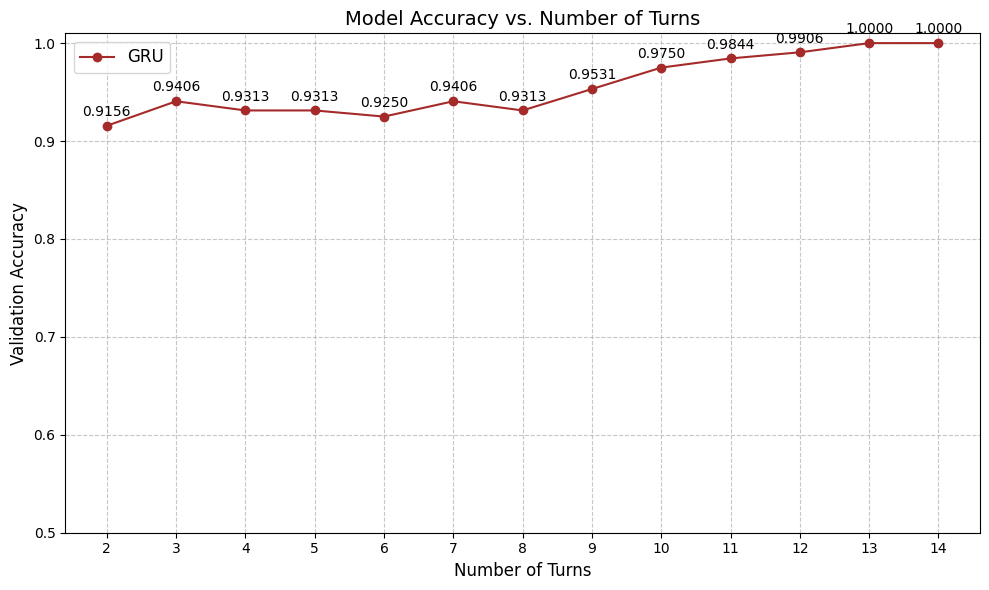

In [ ]:
from huggingface_hub import PyTorchModelHubMixin

# Define the GRU model class
class GRUClassifier(nn.Module, PyTorchModelHubMixin):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout):
        super(GRUClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.gru(embedded)
        output = self.dropout(output[:, -1, :])
        output = self.fc(output)
        return output

model = GRUClassifier.from_pretrained("BothBosu/gru-scam-classifier-v1.6")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

import matplotlib.pyplot as plt

# Create a list to store the accuracies for the GRU model
GRU_accuracies = []

for i, val_loader in enumerate(val_loaders, start=2):
    accuracy = evaluate_model(model, val_loader, device)
    print(f"Validation Accuracy ({i} turns): {accuracy:.4f}")
    GRU_accuracies.append(accuracy)

# Plot the model accuracy graph
turns = range(2, 2 + len(GRU_accuracies))

plt.figure(figsize=(10, 6))
plt.plot(turns, GRU_accuracies, marker='o', linestyle='-', color='brown', label='GRU')

plt.xlabel('Number of Turns', fontsize=12)
plt.ylabel('Validation Accuracy', fontsize=12)
plt.title('Model Accuracy vs. Number of Turns', fontsize=14)

plt.xticks(turns)
plt.ylim(0.5, 1.01)  # Set the y-axis limits starting from 0.5
plt.grid(True, linestyle='--', alpha=0.7)

for i, acc in enumerate(GRU_accuracies):
    plt.text(turns[i], acc + 0.01, f'{acc:.4f}', fontsize=10, ha='center')

plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

config.json:   0%|          | 0.00/104 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/165M [00:00<?, ?B/s]

Validation Accuracy (2 turns): 0.9344
Validation Accuracy (3 turns): 0.9375
Validation Accuracy (4 turns): 0.9313
Validation Accuracy (5 turns): 0.9469
Validation Accuracy (6 turns): 0.9344
Validation Accuracy (7 turns): 0.9531
Validation Accuracy (8 turns): 0.9437
Validation Accuracy (9 turns): 0.9469
Validation Accuracy (10 turns): 0.9625
Validation Accuracy (11 turns): 0.9656
Validation Accuracy (12 turns): 0.9656
Validation Accuracy (13 turns): 0.9719
Validation Accuracy (14 turns): 0.9719


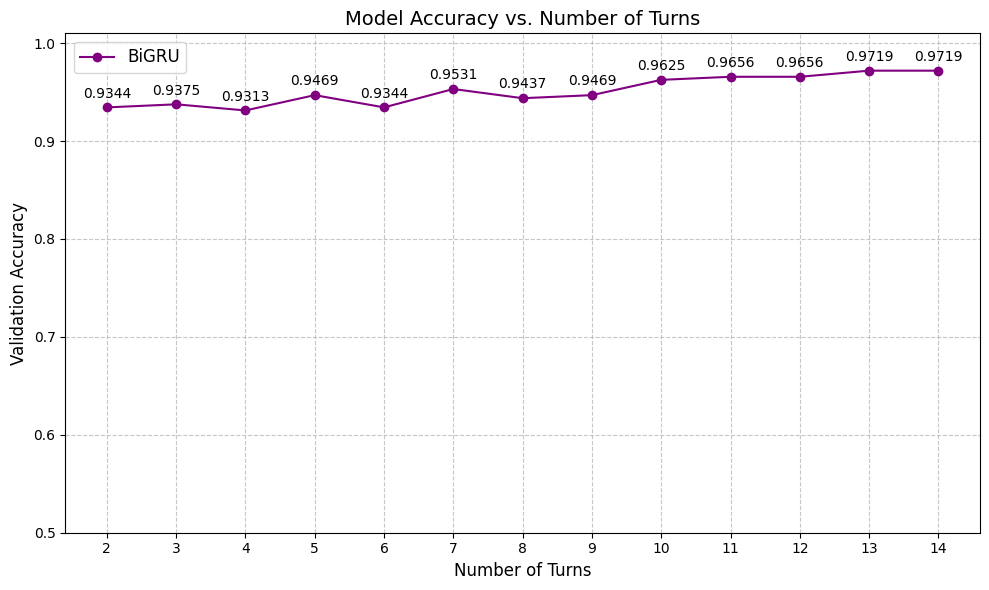

In [ ]:
from huggingface_hub import PyTorchModelHubMixin

# Define the BiGRU model class
class BiGRUClassifier(nn.Module, PyTorchModelHubMixin):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout):
        super(BiGRUClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size * 2, num_classes)  # Multiply hidden_size by 2 for BiGRU
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.gru(embedded)
        output = self.dropout(output[:, -1, :])
        output = self.fc(output)
        return output

model = BiGRUClassifier.from_pretrained("BothBosu/bigru-scam-classifier-v1.6")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

import matplotlib.pyplot as plt

# Create a list to store the accuracies for the BiGRU model
BiGRU_accuracies = []

for i, val_loader in enumerate(val_loaders, start=2):
    accuracy = evaluate_model(model, val_loader, device)
    print(f"Validation Accuracy ({i} turns): {accuracy:.4f}")
    BiGRU_accuracies.append(accuracy)

# Plot the model accuracy graph
turns = range(2, 2 + len(BiGRU_accuracies))

plt.figure(figsize=(10, 6))
plt.plot(turns, BiGRU_accuracies, marker='o', linestyle='-', color='purple', label='BiGRU')

plt.xlabel('Number of Turns', fontsize=12)
plt.ylabel('Validation Accuracy', fontsize=12)
plt.title('Model Accuracy vs. Number of Turns', fontsize=14)

plt.xticks(turns)
plt.ylim(0.5, 1.01)  # Set the y-axis limits starting from 0.5
plt.grid(True, linestyle='--', alpha=0.7)

for i, acc in enumerate(BiGRU_accuracies):
    plt.text(turns[i], acc + 0.01, f'{acc:.4f}', fontsize=10, ha='center')

plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

config.json:   0%|          | 0.00/154 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/16.4M [00:00<?, ?B/s]

Validation Accuracy (2 turns): 0.8594
Validation Accuracy (3 turns): 0.9187
Validation Accuracy (4 turns): 0.9156
Validation Accuracy (5 turns): 0.9594
Validation Accuracy (6 turns): 0.9563
Validation Accuracy (7 turns): 0.9469
Validation Accuracy (8 turns): 0.9500
Validation Accuracy (9 turns): 0.9500
Validation Accuracy (10 turns): 0.9563
Validation Accuracy (11 turns): 0.9656
Validation Accuracy (12 turns): 0.9719
Validation Accuracy (13 turns): 0.9781
Validation Accuracy (14 turns): 0.9781


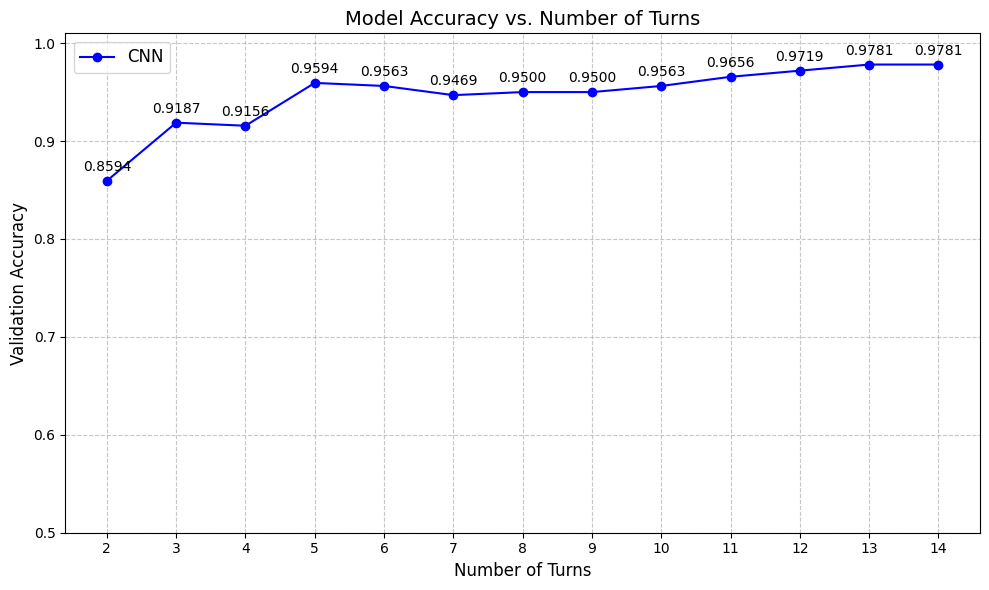

In [ ]:
from huggingface_hub import PyTorchModelHubMixin
import torch.nn.functional as F

# Define the CNN model class
class CNNClassifier(nn.Module, PyTorchModelHubMixin):
    def __init__(self, vocab_size, embedding_dim, num_filters, filter_sizes, num_classes, dropout):
        super(CNNClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embedding_dim, out_channels=num_filters, kernel_size=fs) for fs in filter_sizes
        ])
        self.fc = nn.Linear(len(filter_sizes) * num_filters, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        embedded = embedded.permute(0, 2, 1)
        conved = [F.relu(conv(embedded)) for conv in self.convs]
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        cat = self.dropout(torch.cat(pooled, dim=1))
        output = self.fc(cat)
        return output


model = CNNClassifier.from_pretrained("BothBosu/cnn-scam-classifier-v1.6")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Create a list to store the accuracies
CNN_accuracies = []

for i, val_loader in enumerate(val_loaders, start=2):
    accuracy = evaluate_model(model, val_loader, device)
    print(f"Validation Accuracy ({i} turns): {accuracy:.4f}")
    CNN_accuracies.append(accuracy)

# Plot the model accuracy graph
turns = range(2, 2 + len(CNN_accuracies))

plt.figure(figsize=(10, 6))
plt.plot(turns, CNN_accuracies, marker='o', linestyle='-', color='blue', label='CNN')

plt.xlabel('Number of Turns', fontsize=12)
plt.ylabel('Validation Accuracy', fontsize=12)
plt.title('Model Accuracy vs. Number of Turns', fontsize=14)

plt.xticks(turns)
plt.ylim(0.5, 1.01)
plt.grid(True, linestyle='--', alpha=0.7)

for i, acc in enumerate(CNN_accuracies):
    plt.text(turns[i], acc + 0.01, f'{acc:.4f}', fontsize=10, ha='center')

plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

## Dataset for Transformers

In [ ]:
# Tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Tokenize the dialogue column
def tokenize(batch):
    return tokenizer(batch["dialogue"], padding=True, truncation=True)

# Create data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer) # The collator rename the column label to labels

In [ ]:
test_df_2turn = test_df.copy()
test_df_2turn['dialogue'] = test_df_2turn['dialogue'].apply(lambda x: truncate_dialogue(x, 2))

test_df_3turn = test_df.copy()
test_df_3turn['dialogue'] = test_df_3turn['dialogue'].apply(lambda x: truncate_dialogue(x, 3))

test_df_4turn = test_df.copy()
test_df_4turn['dialogue'] = test_df_4turn['dialogue'].apply(lambda x: truncate_dialogue(x, 4))

test_df_5turn = test_df.copy()
test_df_5turn['dialogue'] = test_df_5turn['dialogue'].apply(lambda x: truncate_dialogue(x, 5))

test_df_6turn = test_df.copy()
test_df_6turn['dialogue'] = test_df_6turn['dialogue'].apply(lambda x: truncate_dialogue(x, 6))

test_df_7turn = test_df.copy()
test_df_7turn['dialogue'] = test_df_7turn['dialogue'].apply(lambda x: truncate_dialogue(x, 7))

test_df_8turn = test_df.copy()
test_df_8turn['dialogue'] = test_df_8turn['dialogue'].apply(lambda x: truncate_dialogue(x, 8))

test_df_9turn = test_df.copy()
test_df_9turn['dialogue'] = test_df_9turn['dialogue'].apply(lambda x: truncate_dialogue(x, 9))

test_df_10turn = test_df.copy()
test_df_10turn['dialogue'] = test_df_10turn['dialogue'].apply(lambda x: truncate_dialogue(x, 10))

test_df_11turn = test_df.copy()
test_df_11turn['dialogue'] = test_df_11turn['dialogue'].apply(lambda x: truncate_dialogue(x, 11))

test_df_12turn = test_df.copy()
test_df_12turn['dialogue'] = test_df_12turn['dialogue'].apply(lambda x: truncate_dialogue(x, 12))

test_df_13turn = test_df.copy()
test_df_13turn['dialogue'] = test_df_13turn['dialogue'].apply(lambda x: truncate_dialogue(x, 13))

test_df_14turn = test_df.copy()
test_df_14turn['dialogue'] = test_df_14turn['dialogue'].apply(lambda x: truncate_dialogue(x, 14))

In [ ]:
from datasets import Dataset

test_df_2turn = Dataset.from_pandas(test_df_2turn)
test_df_2turn = test_df_2turn.map(tokenize, batched=True)

test_df_3turn = Dataset.from_pandas(test_df_3turn)
test_df_3turn = test_df_3turn.map(tokenize, batched=True)

test_df_4turn = Dataset.from_pandas(test_df_4turn)
test_df_4turn = test_df_4turn.map(tokenize, batched=True)

test_df_5turn = Dataset.from_pandas(test_df_5turn)
test_df_5turn = test_df_5turn.map(tokenize, batched=True)

test_df_6turn = Dataset.from_pandas(test_df_6turn)
test_df_6turn = test_df_6turn.map(tokenize, batched=True)

test_df_7turn = Dataset.from_pandas(test_df_7turn)
test_df_7turn = test_df_7turn.map(tokenize, batched=True)

test_df_8turn = Dataset.from_pandas(test_df_8turn)
test_df_8turn = test_df_8turn.map(tokenize, batched=True)

test_df_9turn = Dataset.from_pandas(test_df_9turn)
test_df_9turn = test_df_9turn.map(tokenize, batched=True)

test_df_10turn = Dataset.from_pandas(test_df_10turn)
test_df_10turn = test_df_10turn.map(tokenize, batched=True)

test_df_11turn = Dataset.from_pandas(test_df_11turn)
test_df_11turn = test_df_11turn.map(tokenize, batched=True)

test_df_12turn = Dataset.from_pandas(test_df_12turn)
test_df_12turn = test_df_12turn.map(tokenize, batched=True)

test_df_13turn = Dataset.from_pandas(test_df_13turn)
test_df_13turn = test_df_13turn.map(tokenize, batched=True)

test_df_14turn = Dataset.from_pandas(test_df_14turn)
test_df_14turn = test_df_14turn.map(tokenize, batched=True)

test_dfs = [
    test_df_2turn,
    test_df_3turn,
    test_df_4turn,
    test_df_5turn,
    test_df_6turn,
    test_df_7turn,
    test_df_8turn,
    test_df_9turn,
    test_df_10turn,
    test_df_11turn,
    test_df_12turn,
    test_df_13turn,
    test_df_14turn
]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

### BERT

In [ ]:
from datasets import load_metric
import numpy as np

def evaluate_model(model, dataset, device):
    # Define the metric you want to use for evaluation
    metric = load_metric("accuracy", trust_remote_code=True)

    # Define a function to generate predictions
    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)
        return metric.compute(predictions=predictions, references=labels)

    # Use the map() function to generate predictions
    def generate_predictions(examples):
        input_ids = torch.tensor(examples['input_ids']).to(device)
        attention_mask = torch.tensor(examples['attention_mask']).to(device)
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits.cpu().numpy()
        return {'predictions': logits}

    dataset = dataset.map(generate_predictions, batched=True, batch_size=32)

    # Compute the accuracy
    accuracy = compute_metrics((dataset['predictions'], dataset['labels']))
    print(f"Accuracy: {accuracy['accuracy']:.4f}")

    return accuracy

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Accuracy: 0.5250


Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Accuracy: 0.6625


Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Accuracy: 0.7406


Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Accuracy: 0.8438


Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Accuracy: 0.8875


Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Accuracy: 0.9094


Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Accuracy: 0.9469


Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Accuracy: 0.9750


Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Accuracy: 0.9906


Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Accuracy: 0.9969


Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Accuracy: 0.9938


Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Accuracy: 1.0000


Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Accuracy: 1.0000


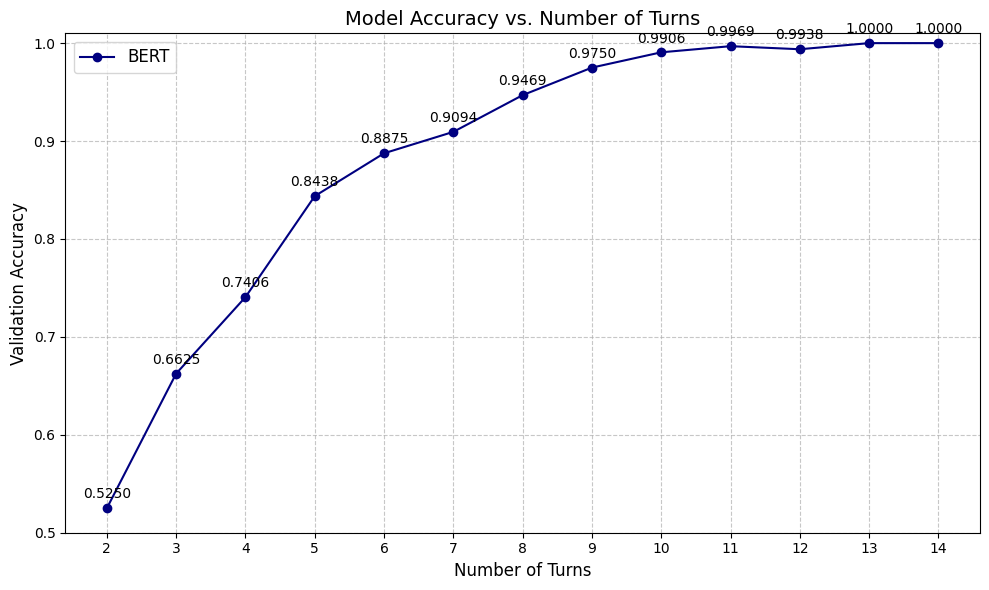

In [ ]:
from transformers import BertForSequenceClassification
import torch

model = BertForSequenceClassification.from_pretrained("BothBosu/bert-scam-classifier-v1.6")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

import matplotlib.pyplot as plt

# Create a list to store the accuracies
BERT_accuracies = []

for df in test_dfs:
    accuracy = evaluate_model(model, df, device)
    BERT_accuracies.append(accuracy['accuracy'])

# Plot the model accuracy graph
turns = range(2, 2 + len(BERT_accuracies))

plt.figure(figsize=(10, 6))
plt.plot(turns, BERT_accuracies, marker='o', linestyle='-', color='navy', label='BERT')

plt.xlabel('Number of Turns', fontsize=12)
plt.ylabel('Validation Accuracy', fontsize=12)
plt.title('Model Accuracy vs. Number of Turns', fontsize=14)

plt.xticks(turns)
plt.ylim(0.5, 1.01)
plt.grid(True, linestyle='--', alpha=0.7)

for i, acc in enumerate(BERT_accuracies):
    plt.text(turns[i], acc + 0.01, f'{acc:.4f}', fontsize=10, ha='center')

plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

### All model are trained up until reaching 1 accuracy

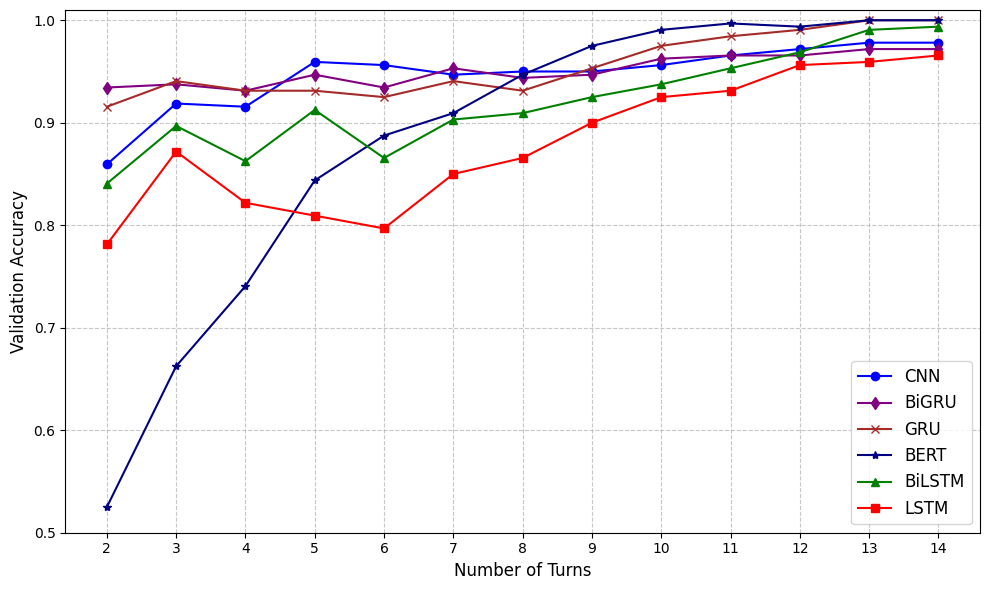

In [ ]:
import matplotlib.pyplot as plt

# Plot the model accuracy graph
turns = range(2, 2 + len(CNN_accuracies))

plt.figure(figsize=(10, 6))

plt.plot(turns, CNN_accuracies, marker='o', linestyle='-', color='blue', label='CNN')
plt.plot(turns, BiGRU_accuracies, marker='d', linestyle='-', color='purple', label='BiGRU')
plt.plot(turns, GRU_accuracies, marker='x', linestyle='-', color='brown', label='GRU')
plt.plot(turns, BERT_accuracies, marker='*', linestyle='-', color='navy', label='BERT')
plt.plot(turns, BiLSTM_accuracies, marker='^', linestyle='-', color='green', label='BiLSTM')
plt.plot(turns, LSTM_accuracies, marker='s', linestyle='-', color='red', label='LSTM')

plt.xlabel('Number of Turns', fontsize=12)
plt.ylabel('Validation Accuracy', fontsize=12)
# plt.title('Model Accuracy vs. Number of Turns (Single-Agent Dataset)', fontsize=14)

plt.xticks(turns)
plt.ylim(0.5, 1.01)  # Set the y-axis limits starting from 0.5
plt.grid(True, linestyle='--', alpha=0.7)

# Add a legend
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()